In [34]:
import numpy as np
import os
import librosa
import librosa.display
import pandas as pd
from IPython import display
from matplotlib import pyplot


from sklearn.ensemble import ExtraTreesClassifier

In [3]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

In [4]:
datasubdir = 'data/'
datadir = os.path.join(os.path.abspath('.'), datasubdir)

In [30]:
subject_names = ['s'+str(i) for i in range(1,10+1)]
trial_names_base = [f'{t}_trial{i}' for t in ['downstairs_nowall', 'downstairs_wall', 'upstairs_nowall', 'upstairs_wall']
                                    for i in range(1,3)]

trial_names = [os.path.join(s, s + '_' + t) 
               for s in subject_names
               for t in trial_names_base]
angle_names = [alph[0] + num[0] + '_' + alph[1] + '_' + num[1]  
               for alph in [('A', '1'), ('B', '3'), ('C', '5')]
               for num in [(str(i),str(45*i)) for i in range(3)]]
recording_paths = [os.path.join(datadir, t,a) for t in trial_names 
                                              for a in angle_names]
recording_paths_rel = [(s,t,a) for s in subject_names
                               for t in trial_names_base 
                               for a in angle_names]

#print(len(recording_paths_rel) == len(recording_paths))
print(*zip(recording_paths_rel, recording_paths))
#print(os.listdir(recording_paths[0]))

(('s1', 'downstairs_nowall_trial1', 'A0_1_0'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/A0_1_0') (('s1', 'downstairs_nowall_trial1', 'A1_1_45'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/A1_1_45') (('s1', 'downstairs_nowall_trial1', 'A2_1_90'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/A2_1_90') (('s1', 'downstairs_nowall_trial1', 'B0_3_0'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/B0_3_0') (('s1', 'downstairs_nowall_trial1', 'B1_3_45'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/B1_3_45') (('s1', 'downstairs_nowall_trial1', 'B2_3_90'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/B2_3_90') (('s1', 'downstairs_nowall_trial1', 'C0_5_0'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstairs_nowall_trial1/C0_5_0') (('s1', 'downstairs_nowall_trial1', 'C1_5_45'), '/home/em/school/cpsc554x/554xproj/data/s1/s1_downstair

In [6]:
# Credit to Yihui Xiong, 2017, https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py

def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [127]:
colnames = ['sample', 'trial', 'angle_pos', 'dov',
                        *[f'gccphat_{i}_{j}_{d}' for i in range(4) for j in range(i+1,4) for d in ['maxshift', 'auc', 'peakval']],
                        *[f'gccphatval_{i}_{j}_{k}' for i in range(4) for j in range(i+1,4) for k in range(23)]]

In [129]:
def get_featurized_data(recording_num):
    df = pd.DataFrame(columns=colnames)
    for pth_ind in range(len(recording_paths)):
        for angle in map(lambda i:45*i, range(360//45)):
            channel_recordings = [os.path.join(recording_paths[pth_ind], f'recording{recording_num}_{angle}_{i}.wav') for i in range(1,5)]
            audio_files = [Audio.fromfile(r) for r in channel_recordings]
            four_channels = [a.data for a in audio_files]
            data_row = {
                'sample': recording_paths_rel[pth_ind][0],
                'trial': recording_paths_rel[pth_ind][1],
                'angle_pos': recording_paths_rel[pth_ind][2],
                'dov': angle 
            }        
            for i in range(4):
                for j in range(i+1,4):
                    gcc_phat_data = gcc_phat(four_channels[i], four_channels[j], 
                                          fs = audio_files[0].rate, max_tau=0.236 * 1e-3, interp=1)
                    data_row[f'gccphat_{i}_{j}_peakval'] = gcc_phat_data[1][11]
                    data_row[f'gccphat_{i}_{j}_auc'] = np.sum(gcc_phat_data[1])
                    data_row[f'gccphat_{i}_{j}_maxshift'] = gcc_phat_data[0]
                    for k in range(23):
                        data_row[f'gccphatval_{i}_{j}_{k}'] = gcc_phat_data[1][k]
            data_rows.append(data_row)
            df = df.append(data_row, ignore_index=True)
    return df

In [48]:
data_rows = []
for pth_ind in range(len(recording_paths)):
    for angle in map(lambda i:45*i, range(360//45)):
        channel_recordings = [os.path.join(recording_paths[pth_ind], f'recording0_{angle}_{i}.wav') for i in range(1,5)]
        audio_files = [Audio.fromfile(r) for r in channel_recordings]
        four_channels = [a.data for a in audio_files]
        data_row = {
            'sample': recording_paths_rel[pth_ind][0],
            'trial': recording_paths_rel[pth_ind][1],
            'angle_pos': recording_paths_rel[pth_ind][2],
            'dov': angle 
        }        
        for i in range(4):
            for j in range(i+1,4):
                gcc_phat_data = gcc_phat(four_channels[i], four_channels[j], 
                                      fs = audio_files[0].rate, max_tau=0.236 * 1e-3, interp=1)
                data_row[f'gccphat_{i}_{j}_peakval'] = gcc_phat_data[1][11]
                data_row[f'gccphat_{i}_{j}_auc'] = np.sum(gcc_phat_data[1])
                data_row[f'gccphat_{i}_{j}_maxshift'] = gcc_phat_data[0]
                for k in range(23):
                    data_row[f'gccphatval_{i}_{j}_{k}'] = gcc_phat_data[1][k]
        data_rows.append(data_row)
        df = df.append(data_row, ignore_index=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [49]:
df

,sample,trial,angle_pos,dov,gccphat_0_1_maxshift,gccphat_0_1_auc,gccphat_0_1_peakval,gccphat_0_2_maxshift,gccphat_0_2_auc,gccphat_0_2_peakval,...,gccphatval_2_3_13,gccphatval_2_3_14,gccphatval_2_3_15,gccphatval_2_3_16,gccphatval_2_3_17,gccphatval_2_3_18,gccphatval_2_3_19,gccphatval_2_3_20,gccphatval_2_3_21,gccphatval_2_3_22
0,s1,downstairs_nowall_trial1,A0_1_0,0,0.000000,0.929901,0.918024,-0.000125,0.802662,-0.081439,...,0.000874,0.057902,0.000011,0.001541,-0.052348,0.000403,0.000849,0.023651,4.840368e-05,0.001163
1,s1,downstairs_nowall_trial1,A0_1_0,45,0.000000,0.935565,0.861144,-0.000125,0.829486,-0.119773,...,0.000171,-0.050401,0.000652,0.000966,0.017136,0.000918,-0.000259,-0.035492,4.432460e-04,0.000769
2,s1,downstairs_nowall_trial1,A0_1_0,90,0.000000,0.977008,0.580438,-0.000063,0.830345,0.062272,...,-0.000743,-0.007790,-0.000195,0.001031,0.055236,0.002341,-0.001265,-0.038105,-5.508172e-04,0.000891
3,s1,downstairs_nowall_trial1,A0_1_0,135,0.000000,0.909018,0.372427,-0.000063,0.872800,0.160522,...,-0.001413,0.076345,-0.000457,0.001607,0.070554,0.003886,-0.000515,-0.046689,-1.150728e-03,0.001109
4,s1,downstairs_nowall_trial1,A0_1_0,180,0.000000,0.897188,0.428891,-0.000063,0.823948,0.131519,...,-0.000334,0.157349,0.002033,0.001508,0.063899,-0.000289,0.000181,-0.036023,9.712151e-04,0.000908
5,s1,downstairs_nowall_trial1,A0_1_0,225,0.000000,0.912079,0.394519,-0.000125,0.853461,0.145651,...,-0.000639,0.207072,-0.000717,0.000789,0.081844,0.002312,-0.000746,-0.015713,-4.173674e-04,0.000286
6,s1,downstairs_nowall_trial1,A0_1_0,270,0.000000,0.945834,0.703730,-0.000125,0.820558,0.046309,...,0.001192,0.165007,0.001008,0.001740,0.006061,0.002051,0.000718,0.045567,3.340538e-04,0.001064
7,s1,downstairs_nowall_trial1,A0_1_0,315,0.000000,0.926344,0.848013,-0.000125,0.834676,-0.007897,...,0.001120,0.154116,0.001274,0.001122,-0.091895,0.000595,0.000989,0.052921,6.801980e-04,0.000992
8,s1,downstairs_nowall_trial1,A1_1_45,0,0.000063,0.947125,-0.123378,0.000000,0.855856,0.898838,...,0.001165,0.097836,0.001311,0.000044,-0.068905,0.000683,0.000548,0.008709,1.352598e-03,-0.000853
9,s1,downstairs_nowall_trial1,A1_1_45,45,0.000063,0.954734,-0.111605,0.000000,0.859415,0.779354,...,0.000457,0.141664,0.001670,-0.000498,-0.076078,0.001355,0.000187,0.029534,1.884021e-03,-0.000281


In [5]:
df.to_csv('data/featurized_data.csv', index=False)

NameError: name 'df' is not defined

In [29]:
df = pd.read_csv('data/featurized_data.csv')

In [51]:
recordings_of_interest_0 = [os.path.join(recording_paths[0], f'recording0_0_{i}.wav') for i in range(1,5)]
audio_files_0 = [Audio.fromfile(r) for r in recordings_of_interest_0]
four_channels_0 = [a.data for a in audio_files_0]
gcc_phat_data_0 = [gcc_phat(four_channels_0[i],four_channels_0[j], fs = audio_files_0[0].rate, max_tau=0.236 * 1e-3, interp=1)
     for i in range(len(four_channels_0))
     for j in range(i+1,len(four_channels_0))]

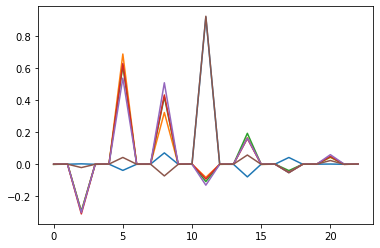

In [52]:
for i in range(len(gcc_phat_data_0)):
    pyplot.plot(gcc_phat_data_0[i][1])

In [64]:
X_df = df.loc[:,list(map(lambda c: c not in ['sample', 'trial', 'angle_pos', 'dov'] and not(c.startswith("Unnamed")), list(df.columns)))]
X = X_df.values
y_df = df.loc[:,"dov"]
y_df = y_df.map(lambda x: int(x in [0,45,90,270,315]))
y = y_df.values
X[np.isnan(X)] = 0

In [80]:
y.shape

(5760,)

In [77]:
tc = ExtraTreesClassifier(n_estimators=1000)
tc.fit(X,y)
#tc_fitted = BaggingClassifier(tc).fit(X,y)

ExtraTreesClassifier(n_estimators=1000)

In [81]:
Z = tc.predict(X) - y
(Z.T @ Z)/Z.size #training error

0.0

In [10]:
test_data=get_featurized_data(1)

NameError: name 'get_featurized_data' is not defined

In [41]:
test_data.to_csv('data/test_data.csv', index=False)

In [82]:
test_data = pd.read_csv('data/test_data.csv')

In [83]:
test_data = test_data.loc[:, list(map(lambda c: not(c.startswith("Unnamed")), test_data.columns))]

In [103]:
X_df_t = test_data.loc[:,list(map(lambda c: c not in ['sample', 'trial', 'angle_pos', 'dov'], list(test_data.columns)))]
Xt = X_df_t.values
y_df_t = test_data.loc[:,"dov"]
y_df_t = y_df_t.map(lambda x: int(x in [0,45,90,270,315]))
yt = y_df_t.values
Xt[np.isnan(Xt)] = 0

In [104]:
X_df_t.columns

Index(['gccphat_0_1_maxshift', 'gccphat_0_1_auc', 'gccphat_0_1_peakval',
       'gccphat_0_2_maxshift', 'gccphat_0_2_auc', 'gccphat_0_2_peakval',
       'gccphat_0_3_maxshift', 'gccphat_0_3_auc', 'gccphat_0_3_peakval',
       'gccphat_1_2_maxshift',
       ...
       'gccphatval_2_3_13', 'gccphatval_2_3_14', 'gccphatval_2_3_15',
       'gccphatval_2_3_16', 'gccphatval_2_3_17', 'gccphatval_2_3_18',
       'gccphatval_2_3_19', 'gccphatval_2_3_20', 'gccphatval_2_3_21',
       'gccphatval_2_3_22'],
      dtype='object', length=156)

In [105]:
Zt = (tc.predict(Xt) - yt)
(Zt.T @ Zt) / Zt.size

0.1638888888888889

In [94]:
y_df2 = df.loc[:,"dov"]
y_df2 = y_df2.map(lambda x: int(x in [0,45,315]))
y2 = y_df2.values

In [101]:
y_df_t = test_data.loc[:,"dov"]
y_df_t = y_df_t.map(lambda x: int(x in [0,45,315]))
yt2 = y_df_t.values

In [97]:
tc2 = ExtraTreesClassifier(n_estimators=1000)
tc2.fit(X,y2)
#tc2_fitted = BaggingClassifier(tc2).fit(X,y)

ExtraTreesClassifier(n_estimators=1000)

In [98]:
Z = tc2.predict(X) - y2
(Z.T @ Z)/Z.size #training error

0.0

In [102]:
Zt = (tc2.predict(Xt) - yt2)
(Zt.T @ Zt) / Zt.size

0.13923611111111112

In [100]:
import pickle
with open('data/fitted_classifier_45.pkl', 'wb') as f:
    pickle.dump(tc2, f)
with open('data/fitted_classifier_90.pkl', 'wb') as f:
    pickle.dump(tc, f)